# 9: Machine Learning Operations

There are two hand in exercises for this topic:
1. First, one is in the notebook - ‘mlflow_task.ipynb’. Complete all the tasks in this
notebook.
2. Second, one is in the notebook - ‘MLOps exercises.ipynb’. Do tasks 1 – 6 in this notebook

### Assemble + Installs + Imports

Loading the df like in the TSA_example notebook

In [60]:
# Lib imports for the notebook
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
import pandas as pd
import matplotlib.pyplot as plt
import subprocess
import time
import IPython.display as display
import tempfile
import kagglehub
import os

In [61]:
# Download latest version
path = kagglehub.dataset_download("robikscube/hourly-energy-consumption")

print("Path to dfset files:", path)

Path to dfset files: C:\Users\danie\.cache\kagglehub\datasets\robikscube\hourly-energy-consumption\versions\3


In [62]:
dataset_path = "C:/Users/danie/.cache/kagglehub/datasets/robikscube/hourly-energy-consumption/versions/3"

files = os.listdir(dataset_path)
print(files)

['AEP_hourly.csv', 'COMED_hourly.csv', 'DAYTON_hourly.csv', 'DEOK_hourly.csv', 'DOM_hourly.csv', 'DUQ_hourly.csv', 'EKPC_hourly.csv', 'est_hourly.paruqet', 'FE_hourly.csv', 'NI_hourly.csv', 'PJME_hourly.csv', 'PJMW_hourly.csv', 'pjm_hourly_est.csv', 'PJM_Load_hourly.csv']


In [63]:
file_path = "C:/Users/danie/.cache/kagglehub/datasets/robikscube/hourly-energy-consumption/versions/3/PJME_hourly.csv"

In [64]:
df1 = pd.read_csv(file_path)
df1 = df1.set_index('Datetime')
df1.index = pd.to_datetime(df1.index)
df = df1.sort_index()
df = df1.sample(1000)

### Initial EDA and datacleaning

In [65]:
df.head(10)

,PJME_MW
Datetime,
2003-02-27 04:00:00,30565.0
2007-05-22 23:00:00,30008.0
2015-09-10 15:00:00,39809.0
2011-01-03 18:00:00,40205.0
2003-12-29 01:00:00,27221.0
2012-04-04 21:00:00,30873.0
2007-01-07 18:00:00,33147.0
2007-09-22 00:00:00,30200.0
2007-12-26 02:00:00,27260.0


In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1000 entries, 2003-02-27 04:00:00 to 2011-07-09 17:00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   PJME_MW  1000 non-null   float64
dtypes: float64(1)
memory usage: 15.6 KB


In [67]:
df.describe()

,PJME_MW
count,1000.000000
mean,31955.896000
std,6234.860477
min,19761.000000
25%,27398.500000
50%,31354.500000
75%,35527.750000
max,59502.000000


---

## Execise 1

In this exercise, do the following:
1. Load the dataset used in the time series example - Energy consumption data. You can find it in the notebook "TSA_Example" in Time Series folder in Moodle.
2. Setup a nested MLFlow loop where different modelling experiments can be tracked and the use the dataset in point 1 to experiment and track models. You should do following combinations:
    1. At least 3 model types
    2. At least 3 different feature combinations
    3. At least 3 different options for 3 different hyperparameters
    4. At least 3 different time splits for train test
3. For each option in the combination, you should calculate & log the following in MLFlow:
    1. RMSE
    2. MAE
    3. Plot of actual vs predicted for 1 month data
    4. Plot of actual vs predicted for 1 week of data
    5. All of the combination info in point 2, such as which model, what feature combindation, what hyperparameter, what train test split has been used
4. Turn on MLFlow UI and track your experiments

### Prepare features for fitting

In [68]:
# First lets do some simple feature engineering, so we have some features to work with
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month

In [69]:
# Feature selection
# Features: hour, day_of_week, month
# Target: PJME_MW
target = 'PJME_MW'
X = df.drop(columns=[target])
y = df[target]
X

,hour,day_of_week,month
Datetime,,,
2003-02-27 04:00:00,4,3,2
2007-05-22 23:00:00,23,1,5
2015-09-10 15:00:00,15,3,9
2011-01-03 18:00:00,18,0,1
2003-12-29 01:00:00,1,0,12
...,...,...,...
2016-03-29 10:00:00,10,1,3
2011-08-26 22:00:00,22,4,8
2015-03-15 05:00:00,5,6,3


In [70]:
# feature combinations last 2, first 2 and all
features_combinations = [
    ['hour', 'day_of_week'],
    ['day_of_week', 'month'],
    ['hour', 'day_of_week', 'month']
]
features_combinations

[['hour', 'day_of_week'],
 ['day_of_week', 'month'],
 ['hour', 'day_of_week', 'month']]

In [71]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Start a new MLFLOW experiment, train models and monitor them using the UI

In [72]:
# Set the MLFlow tracking URI (optional, if not using the default)
mlflow.set_tracking_uri("http://localhost:5000")
# new experiment
mlflow.set_experiment("energy-consumption tracking experiment")
# empty results list
results = []

Im going to use a combination KNN, Logistic Regression and Decision Tree which are all classifier model. From this experiment i hope to find out which classifier performs the best on the dataset im using.

🏃 View run KNeighborsClassifier with features ['hour', 'day_of_week'] at: http://localhost:5000/#/experiments/953748094883213223/runs/b64b89209f554a0eb0473b40c5310de3
🧪 View experiment at: http://localhost:5000/#/experiments/953748094883213223


🏃 View run LogisticRegression with features ['hour', 'day_of_week'] at: http://localhost:5000/#/experiments/953748094883213223/runs/e4bbf877b43844f1be9fe9253cc605f9
🧪 View experiment at: http://localhost:5000/#/experiments/953748094883213223


🏃 View run DecisionTreeClassifier with features ['hour', 'day_of_week'] at: http://localhost:5000/#/experiments/953748094883213223/runs/491f54ff8e2542d285941390f2f4eb0f
🧪 View experiment at: http://localhost:5000/#/experiments/953748094883213223


🏃 View run KNeighborsClassifier with features ['day_of_week', 'month'] at: http://localhost:5000/#/experiments/953748094883213223/runs/a088aa4540c743dfa8c2668e2aa949e6
🧪 View experiment at: http://localhost:5000/#/experiments/953748094883213223


🏃 View run LogisticRegression with features ['day_of_week', 'month'] at: http://localhost:5000/#/experiments/953748094883213223/runs/ee3dbd3ecf8a4698a077d7dd0fc9715d
🧪 View experiment at: http://localhost:5000/#/experiments/953748094883213223


🏃 View run DecisionTreeClassifier with features ['day_of_week', 'month'] at: http://localhost:5000/#/experiments/953748094883213223/runs/dbe4fecf0077454a9a1b0d211b73380b
🧪 View experiment at: http://localhost:5000/#/experiments/953748094883213223


🏃 View run KNeighborsClassifier with features ['hour', 'day_of_week', 'month'] at: http://localhost:5000/#/experiments/953748094883213223/runs/a445c31a41154cc09ba21a66bcc185d6
🧪 View experiment at: http://localhost:5000/#/experiments/953748094883213223


🏃 View run LogisticRegression with features ['hour', 'day_of_week', 'month'] at: http://localhost:5000/#/experiments/953748094883213223/runs/7baafd7c958d4c36ac04b50af969ce3d
🧪 View experiment at: http://localhost:5000/#/experiments/953748094883213223


🏃 View run DecisionTreeClassifier with features ['hour', 'day_of_week', 'month'] at: http://localhost:5000/#/experiments/953748094883213223/runs/85831b1c2a5144979ccf8ef531ca0aa4
🧪 View experiment at: http://localhost:5000/#/experiments/953748094883213223

Summary of Experiment Results:
                     features                   model          rmse       mae
0         [hour, day_of_week]    KNeighborsClassifier   7307.857960  5481.265
1         [hour, day_of_week]      LogisticRegression   6503.506794  4909.435
2         [hour, day_of_week]  DecisionTreeClassifier   7906.269968  6114.860
3        [day_of_week, month]    KNeighborsClassifier   9254.429891  7312.265
4        [day_of_week, month]      LogisticRegression   8233.366201  6346.190
5        [day_of_week, month]  DecisionTreeClassifier  10884.753834  8827.860
6  [hour, day_of_week, month]    KNeighborsClassifier   6507.165990  4724.975
7  [hour, day_of_week, month]      LogisticRegression   6367.638553  4647.145
8  [hour, d

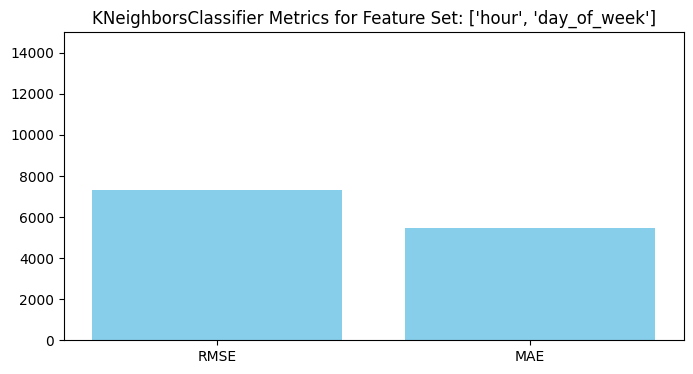

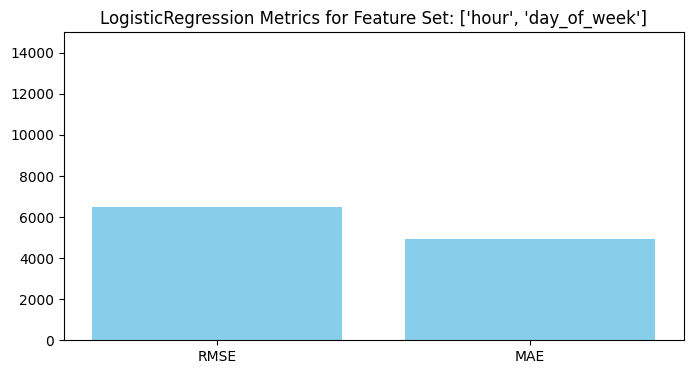

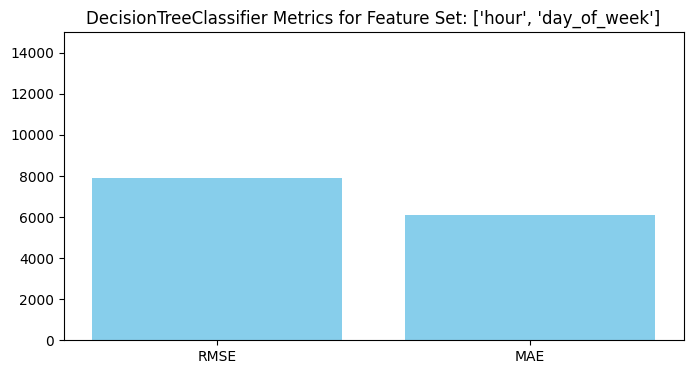

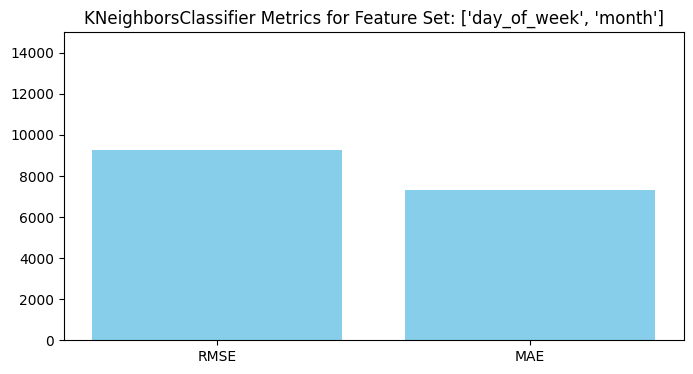

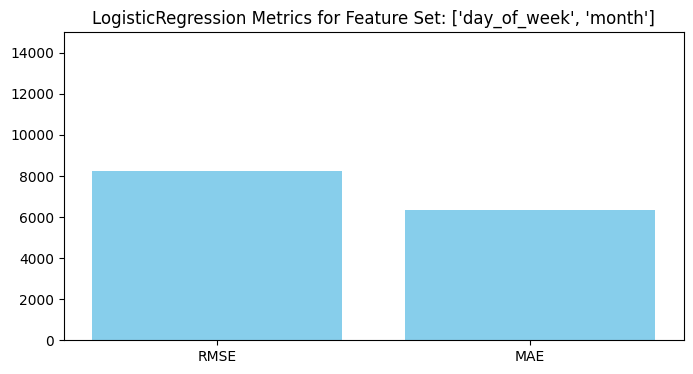

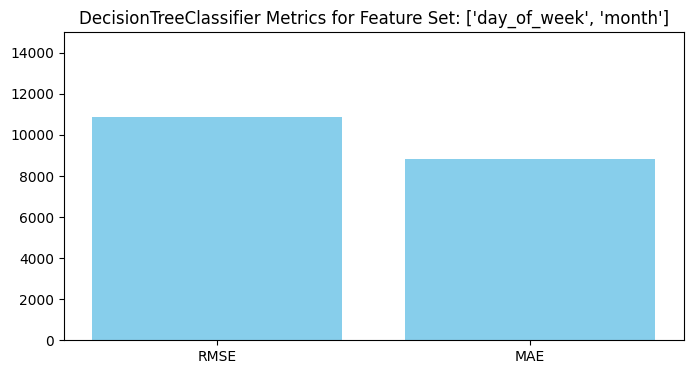

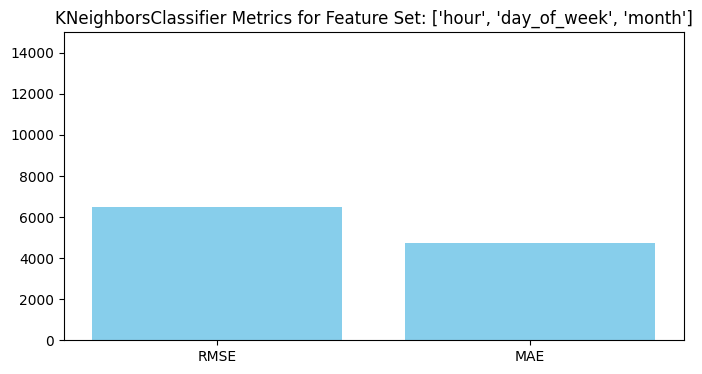

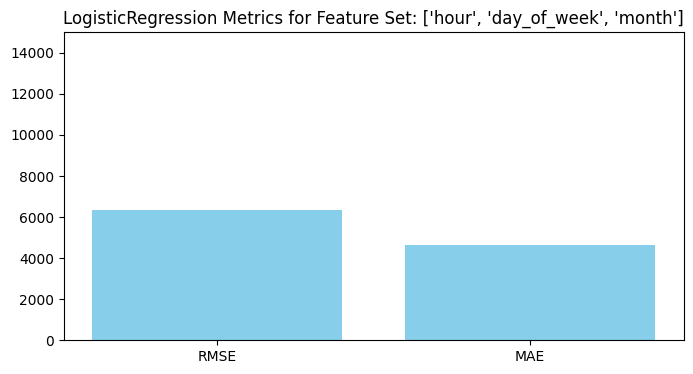

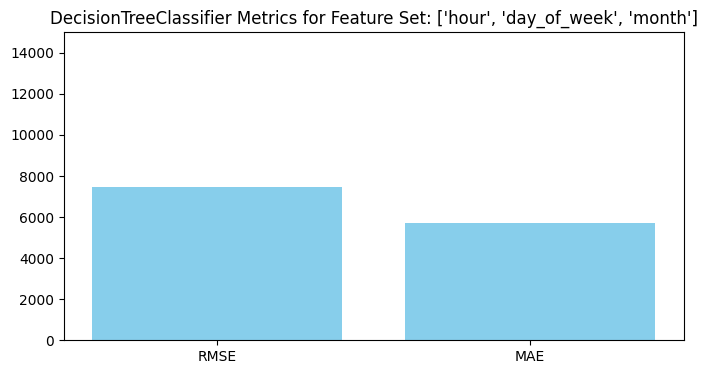

In [73]:
# For loop to train models with different feature combinations
for feature in features_combinations:
    for model_name, model in zip(
        ["KNeighborsClassifier", "LogisticRegression", "DecisionTreeClassifier"],
        [KNeighborsClassifier(n_neighbors=6), LogisticRegression(max_iter=2000), DecisionTreeClassifier(max_depth=5)]
    ):
        with mlflow.start_run():
            # Set a custom run name to make sense of the results in MLFlow UI
            run_name = f"{model_name} with features {feature}"
            mlflow.set_tag("mlflow.runName", run_name)
            # I log the feature combination and the current model name
            mlflow.log_param("features", feature)
            mlflow.log_param("model", model_name)
            # I train the current index model
            model.fit(X_train[feature], y_train)
            pred = model.predict(X_test[feature])
            # Calc the accuracy metrics for currnet model
            rmse = root_mean_squared_error(y_test, pred)
            mae = mean_absolute_error(y_test, pred)
            # Now log the metrics for current indexed model
            mlflow.log_metric("rmse", rmse)
            mlflow.log_metric("mae", mae)
            # Do some visualization
            fig, ax = plt.subplots(figsize=(8, 4))
            metrics = [rmse, mae]
            metric_names = ["RMSE", "MAE"]
            ax.bar(metric_names, metrics, color='skyblue')
            ax.set_title(f"{model_name} Metrics for Feature Set: {feature}")
            ax.set_ylim(0, 15000)
            # Save the plot to a temporary file and log it as an artifact
            temp_file = tempfile.NamedTemporaryFile(suffix=".png", delete=False)
            plt.savefig(temp_file.name)
            mlflow.log_artifact(temp_file.name, artifact_path="plots")
            temp_file.close()
            # Log the model with input example
            input_example = X_test[feature].iloc[:5].astype('float64')
            mlflow.sklearn.log_model(model, model_name, input_example=input_example)
            # Store results for summary
            results.append({
                "features": feature,
                "model": model_name,
                "rmse": rmse,
                "mae": mae
            })


# Print summary of results
results_df = pd.DataFrame(results)
print("\nSummary of Experiment Results:")
print(results_df)

In [74]:
# Start MLFlow UI from the notebook
print("\nStarting MLFlow UI...")
process = subprocess.Popen(["mlflow", "ui", "--port", "5000"])  # Starts MLFlow UI on port 5000
# Wait a moment to ensure the server starts
time.sleep(3)
# Display a link to the MLFlow UI
display.display(display.Markdown("[Open MLFlow UI](http://localhost:5000)"))
print("MLFlow UI is running at http://localhost:5000. Press Ctrl+C in the terminal to stop it.")


Starting MLFlow UI...


[Open MLFlow UI](http://localhost:5000)

MLFlow UI is running at http://localhost:5000. Press Ctrl+C in the terminal to stop it.


In [75]:
!mlflow ui

^C
